In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit 
from scipy.stats import linregress


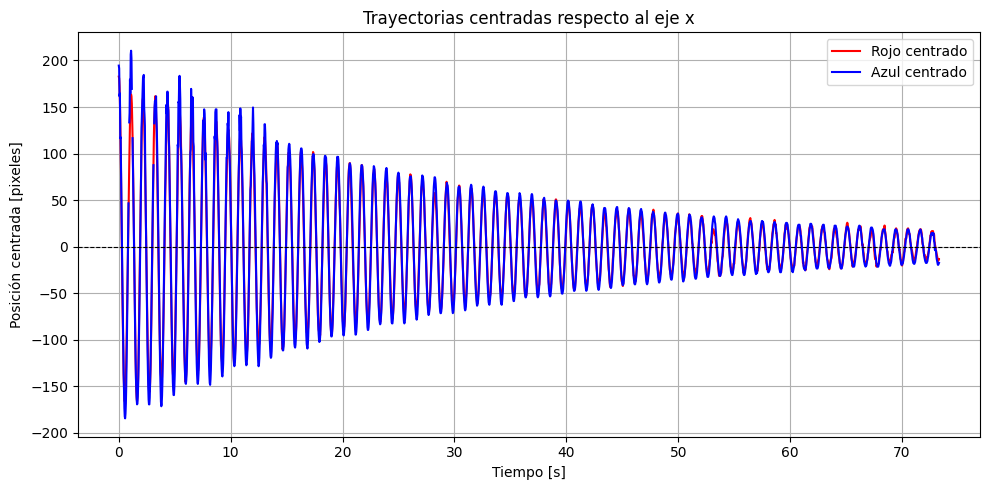

In [2]:
# Cargar el DataFrame
df = pd.read_csv('/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosaModoLento/trayectorias.csv')

# Centrar las posiciones en x alrededor de su media
df['x_rojo_centrado'] = df['x_rojo'] - df['x_rojo'].mean()
df['x_azul_centrado'] = df['x_azul'] - df['x_azul'].mean()

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(df['tiempo_s'], df['x_rojo_centrado'], label='Rojo centrado', color='red')
plt.plot(df['tiempo_s'], df['x_azul_centrado'], label='Azul centrado', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición centrada [pixeles]')
plt.title('Trayectorias centradas respecto al eje x')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

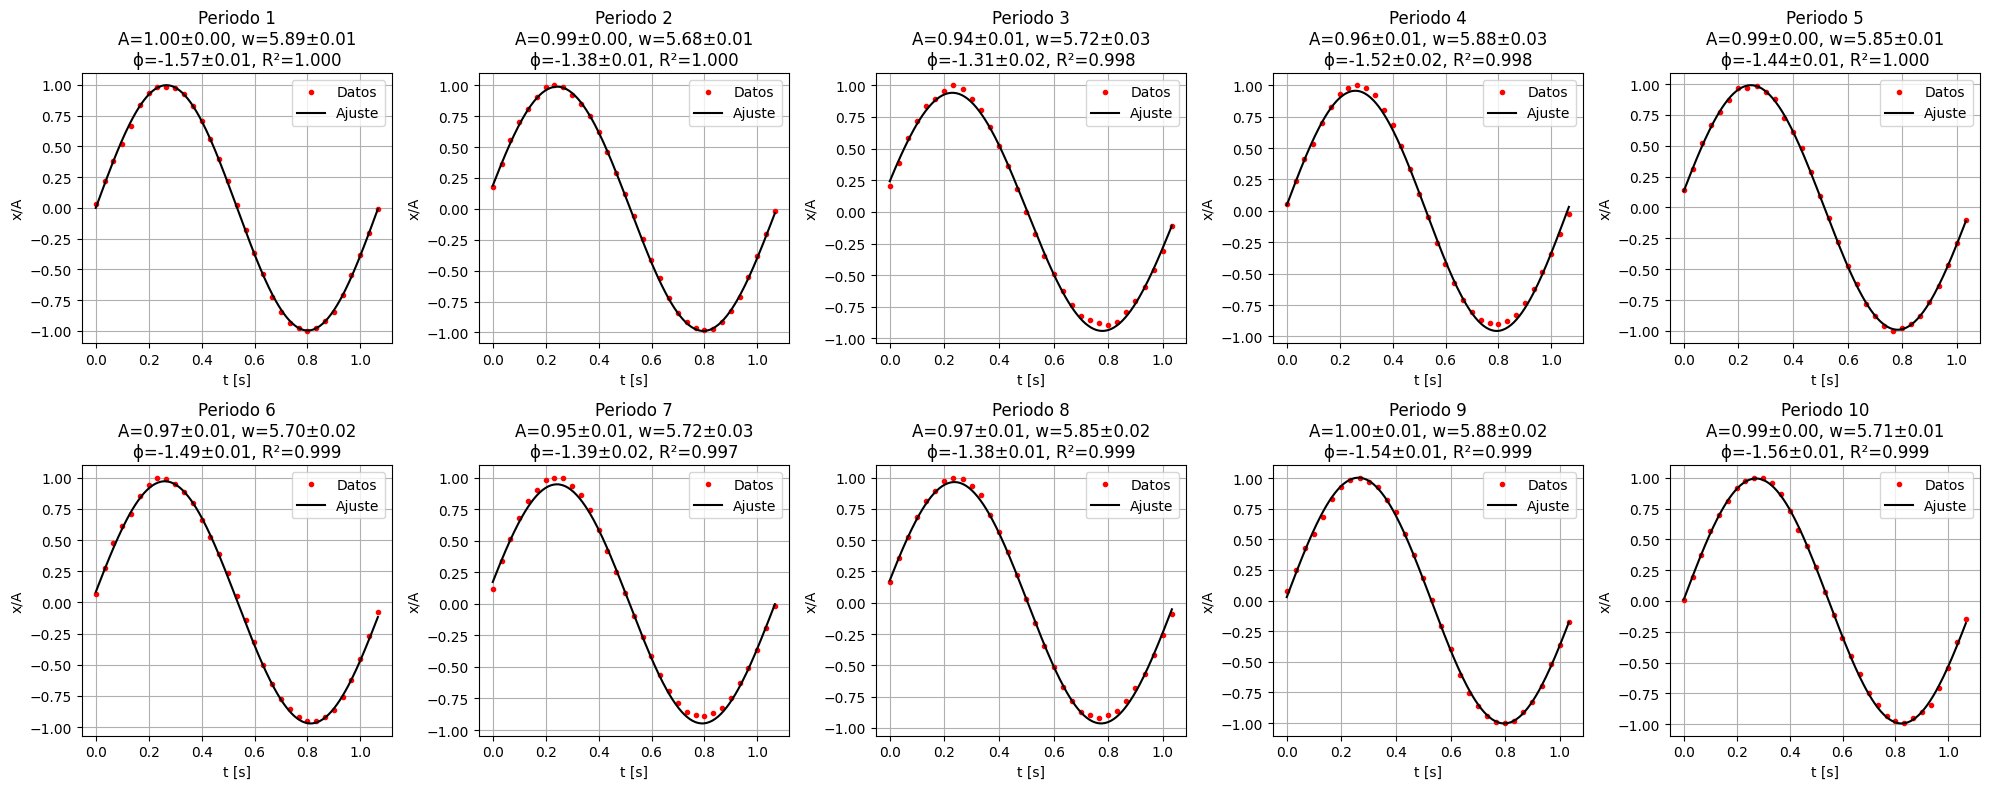

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1. Cargar datos
df = pd.read_csv('/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosaModoLento/trayectorias.csv')

# 2. Centrar señal roja
df['x_rojo_centrado'] = df['x_rojo'] - df['x_rojo'].mean()
x = df['x_rojo_centrado'].values
t = df['tiempo_s'].values

# 3. Detectar cruces por cero positivos
cruces_cero = []
for i in range(1, len(x)):
    if x[i-1] < 0 and x[i] >= 0:
        t0 = t[i-1] + (0 - x[i-1]) * (t[i] - t[i-1]) / (x[i] - x[i-1])
        cruces_cero.append((i, t0))

# 4. Separar periodos normalizados
periodos = []
for i in range(len(cruces_cero)-1):
    idx_inicio = cruces_cero[i][0]
    idx_fin = cruces_cero[i+1][0]
    t_periodo = t[idx_inicio:idx_fin]
    x_periodo = x[idx_inicio:idx_fin]
    A = np.max(np.abs(x_periodo))
    if A != 0:
        x_normalizado = x_periodo / A
        periodos.append((t_periodo - t_periodo[0], x_normalizado))

# 5. Definir función a ajustar
def modelo(t, A, w, phi):
    return A * np.cos(w * t + phi)

# 6. Ajustar y graficar
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(min(10, len(periodos))):
    t_i, x_i = periodos[i]

    # Estimaciones iniciales: A=1, w=2pi/T (T ~ duración), phi=0
    T_estimado = t_i[-1] - t_i[0]
    p0 = [1, 2*np.pi / T_estimado, 0]

    try:
        popt, pcov = curve_fit(modelo, t_i, x_i, p0=p0)
        A_fit, w_fit, phi_fit = popt
        errores = np.sqrt(np.diag(pcov))
        A_err, w_err, phi_err = errores

        # Calcular R^2
        resid = x_i - modelo(t_i, *popt)
        ss_res = np.sum(resid**2)
        ss_tot = np.sum((x_i - np.mean(x_i))**2)
        r2 = 1 - ss_res / ss_tot

        # Graficar
        axes[i].plot(t_i, x_i, 'r.', label='Datos')
        t_fit = np.linspace(t_i.min(), t_i.max(), 200)
        axes[i].plot(t_fit, modelo(t_fit, *popt), 'k-', label='Ajuste')
        axes[i].set_title(f'Periodo {i+1}\nA={A_fit:.2f}±{A_err:.2f}, w={w_fit:.2f}±{w_err:.2f}\n'
                          f'ϕ={phi_fit:.2f}±{phi_err:.2f}, R²={r2:.3f}')
        axes[i].grid(True)
        axes[i].legend()
        axes[i].set_xlabel("t [s]")
        axes[i].set_ylabel("x/A")

    except Exception as e:
        axes[i].plot(t_i, x_i, 'r.')
        axes[i].set_title(f'Periodo {i+1}\nAjuste fallido')
        print(f"Fallo en ajuste periodo {i+1}: {e}")

plt.tight_layout()
plt.show()


=== Procesando señal x_rojo ===


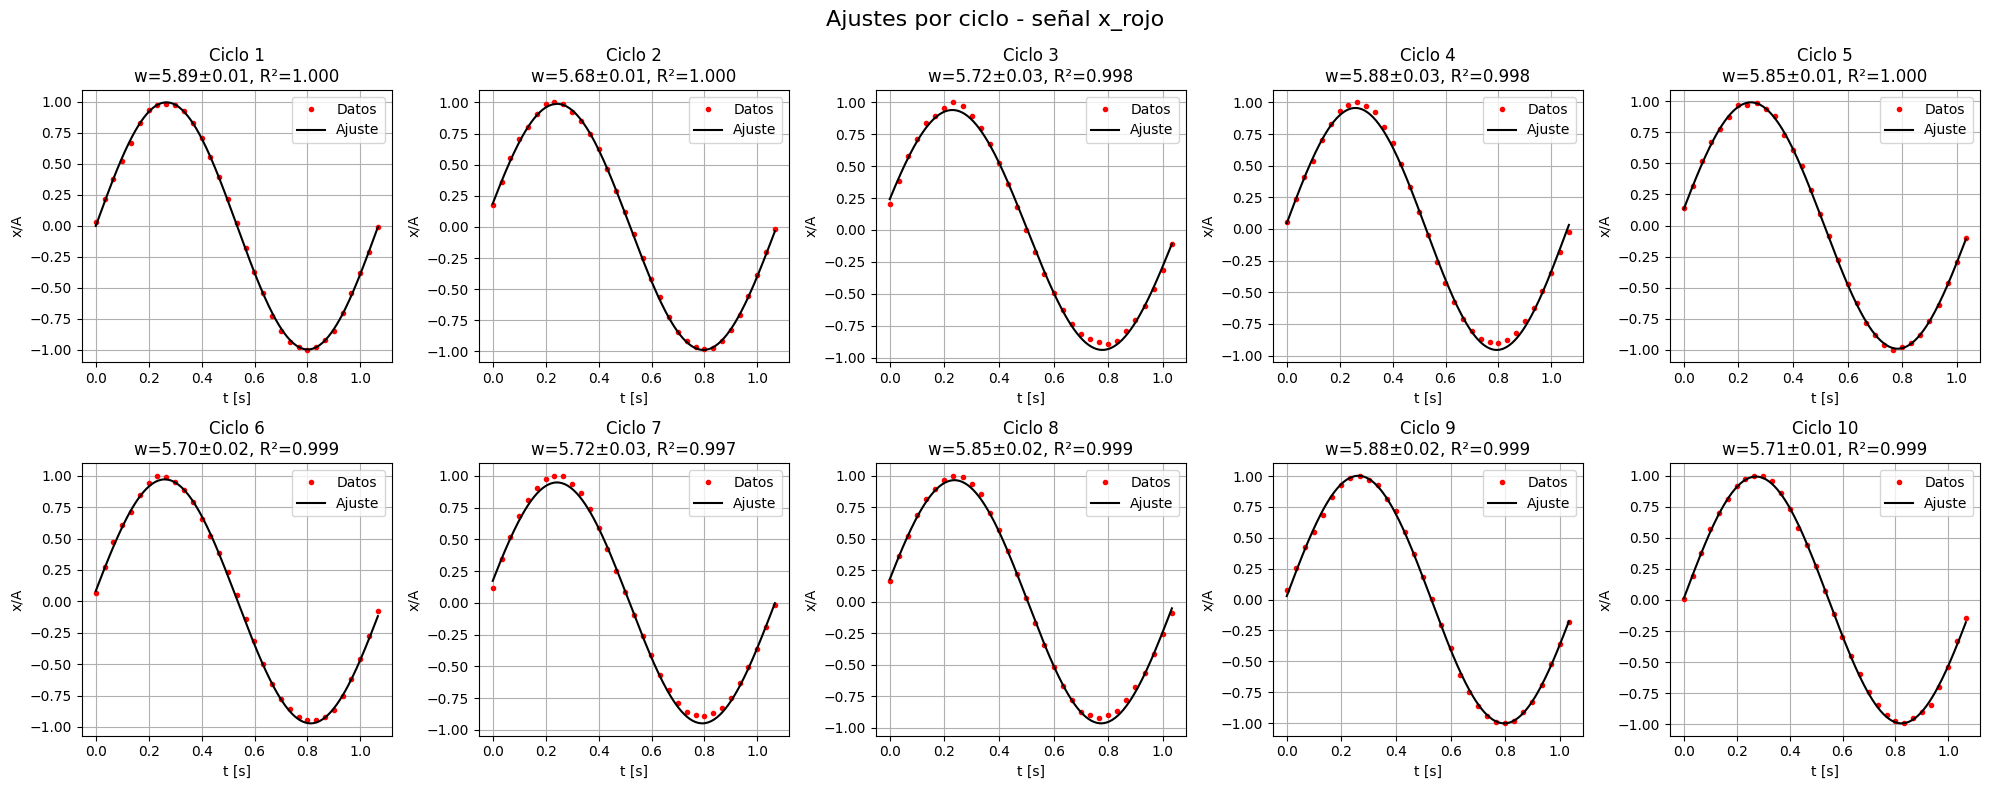

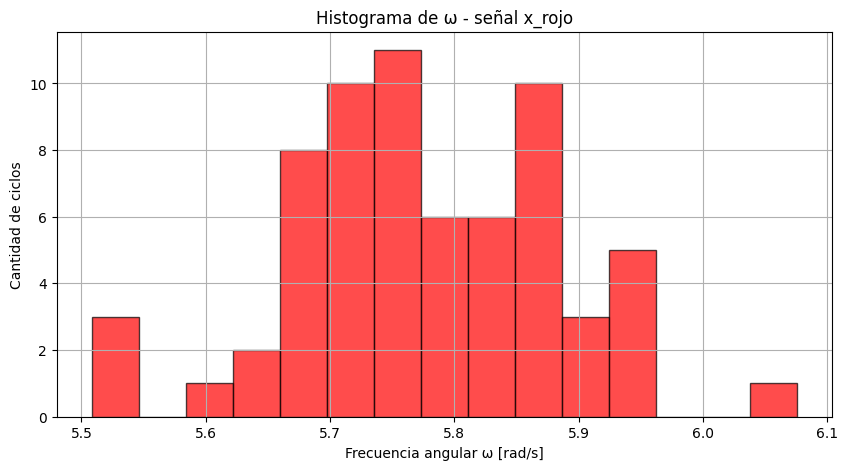


Resultados ω para x_rojo:
ω promedio = 5.777 rad/s
Desvío estándar = 0.108 rad/s
N ciclos usados = 66

=== Procesando señal x_azul ===
Ajuste fallido en ciclo 1: array must not contain infs or NaNs
Ajuste fallido en ciclo 3: array must not contain infs or NaNs


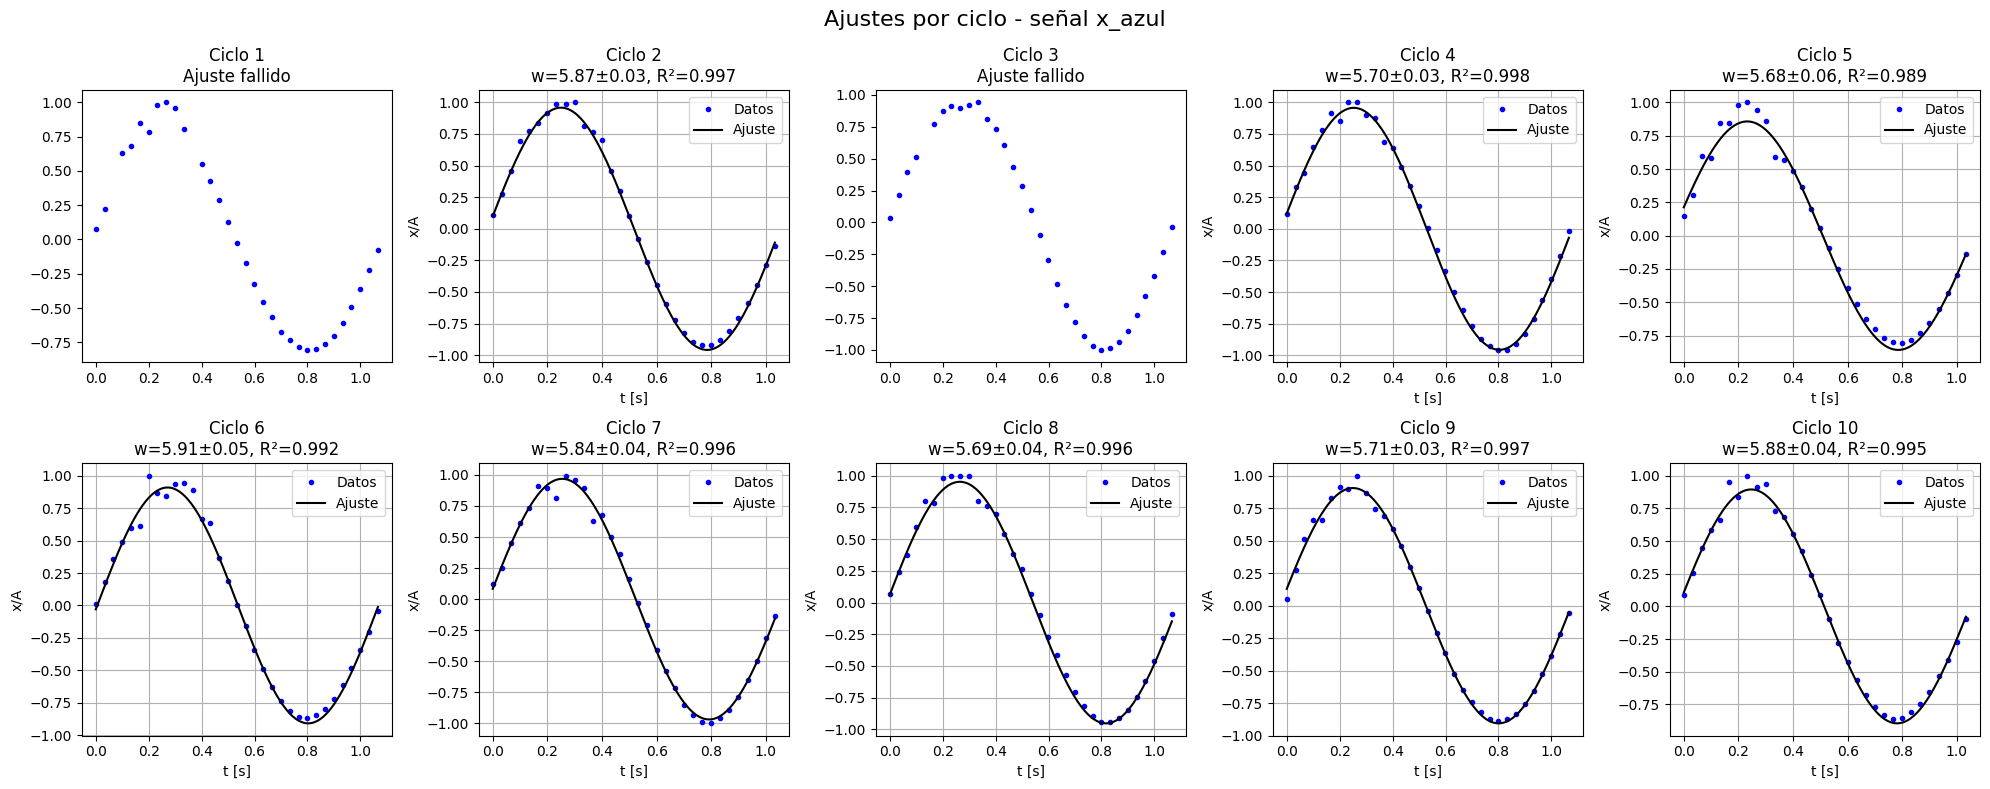

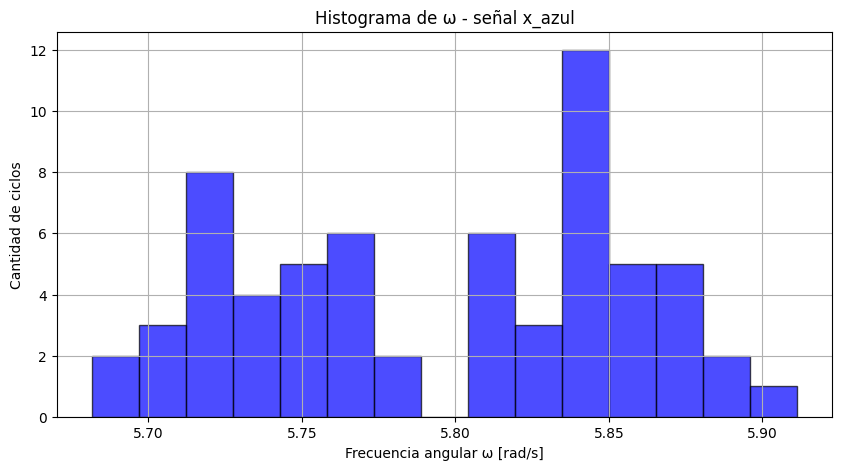


Resultados ω para x_azul:
ω promedio = 5.794 rad/s
Desvío estándar = 0.061 rad/s
N ciclos usados = 64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Parámetro para filtrar por calidad de ajuste
usar_filtro = False
umbral_r2 = 0.9

# Cargar datos
ruta = '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosaModoLento/trayectorias.csv'
df = pd.read_csv(ruta)
t = df['tiempo_s'].values

def procesar_senal(nombre_columna, color_plot):
    print(f"\n=== Procesando señal {nombre_columna} ===")

    # Centrar señal
    x = df[nombre_columna] - df[nombre_columna].mean()

    # Detección de cruces por cero positivos
    cruces_cero = []
    for i in range(1, len(x)):
        if x[i-1] < 0 and x[i] >= 0:
            t0 = t[i-1] + (0 - x[i-1]) * (t[i] - t[i-1]) / (x[i] - x[i-1])
            cruces_cero.append((i, t0))

    # División en periodos y normalización
    periodos = []
    for i in range(len(cruces_cero)-1):
        idx_i, _ = cruces_cero[i]
        idx_f, _ = cruces_cero[i+1]
        t_i = t[idx_i:idx_f]
        x_i = x[idx_i:idx_f]
        A = np.max(np.abs(x_i))
        if A != 0:
            x_norm = x_i / A
            periodos.append((t_i - t_i[0], x_norm))

    # Modelo para ajuste
    def modelo(t, A, w, phi):
        return A * np.cos(w * t + phi)

    # Ajuste de cada ciclo
    w_vals = []
    w_errs = []
    r2_vals = []

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, (t_i, x_i) in enumerate(periodos):
        if i < 10:  # solo graficar los primeros 10
            ax = axes[i]

        T_est = t_i[-1] - t_i[0]
        p0 = [1, 2*np.pi/T_est, 0]

        try:
            popt, pcov = curve_fit(modelo, t_i, x_i, p0=p0)
            A_fit, w_fit, phi_fit = popt
            perr = np.sqrt(np.diag(pcov))
            A_err, w_err, phi_err = perr

            # Cálculo de R²
            resid = x_i - modelo(t_i, *popt)
            ss_res = np.sum(resid**2)
            ss_tot = np.sum((x_i - np.mean(x_i))**2)
            r2 = 1 - ss_res / ss_tot

            if (not usar_filtro) or (usar_filtro and r2 >= umbral_r2):
                w_vals.append(w_fit)
                w_errs.append(w_err)
                r2_vals.append(r2)

                if i < 10:
                    t_fit = np.linspace(t_i.min(), t_i.max(), 200)
                    ax.plot(t_i, x_i, f'{color_plot}.', label='Datos')
                    ax.plot(t_fit, modelo(t_fit, *popt), 'k-', label='Ajuste')
                    ax.set_title(f'Ciclo {i+1}\nw={w_fit:.2f}±{w_err:.2f}, R²={r2:.3f}')
                    ax.legend()
                    ax.grid(True)
                    ax.set_xlabel("t [s]")
                    ax.set_ylabel("x/A")
            else:
                if i < 10:
                    ax.plot(t_i, x_i, f'{color_plot}.')
                    ax.set_title(f'Ciclo {i+1}\nR²={r2:.3f} (descartado)')
                    ax.grid(True)

        except Exception as e:
            if i < 10:
                ax.plot(t_i, x_i, f'{color_plot}.')
                ax.set_title(f'Ciclo {i+1}\nAjuste fallido')
            print(f"Ajuste fallido en ciclo {i+1}: {e}")

    # Mostrar gráfica de los 10 ciclos
    plt.suptitle(f"Ajustes por ciclo - señal {nombre_columna}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    # Histograma de frecuencias
    if w_vals:
        w_vals = np.array(w_vals)
        w_errs = np.array(w_errs)

        plt.figure(figsize=(10, 5))
        plt.hist(w_vals, bins=15, color=color_plot, edgecolor='k', alpha=0.7)
        plt.xlabel("Frecuencia angular ω [rad/s]")
        plt.ylabel("Cantidad de ciclos")
        plt.title(f"Histograma de ω - señal {nombre_columna}")
        plt.grid(True)
        plt.show()

        # Estadísticas
        w_mean = np.mean(w_vals)
        w_std = np.std(w_vals, ddof=1)
        print(f"\nResultados ω para {nombre_columna}:")
        print(f"ω promedio = {w_mean:.3f} rad/s")
        print(f"Desvío estándar = {w_std:.3f} rad/s")
        print(f"N ciclos usados = {len(w_vals)}")

    else:
        print("No se obtuvieron ajustes válidos para esta señal.")

# Ejecutar análisis para ambas señales
procesar_senal('x_rojo', 'r')
procesar_senal('x_azul', 'b')

Fallo en periodo 1: array must not contain infs or NaNs
Fallo en periodo 3: array must not contain infs or NaNs


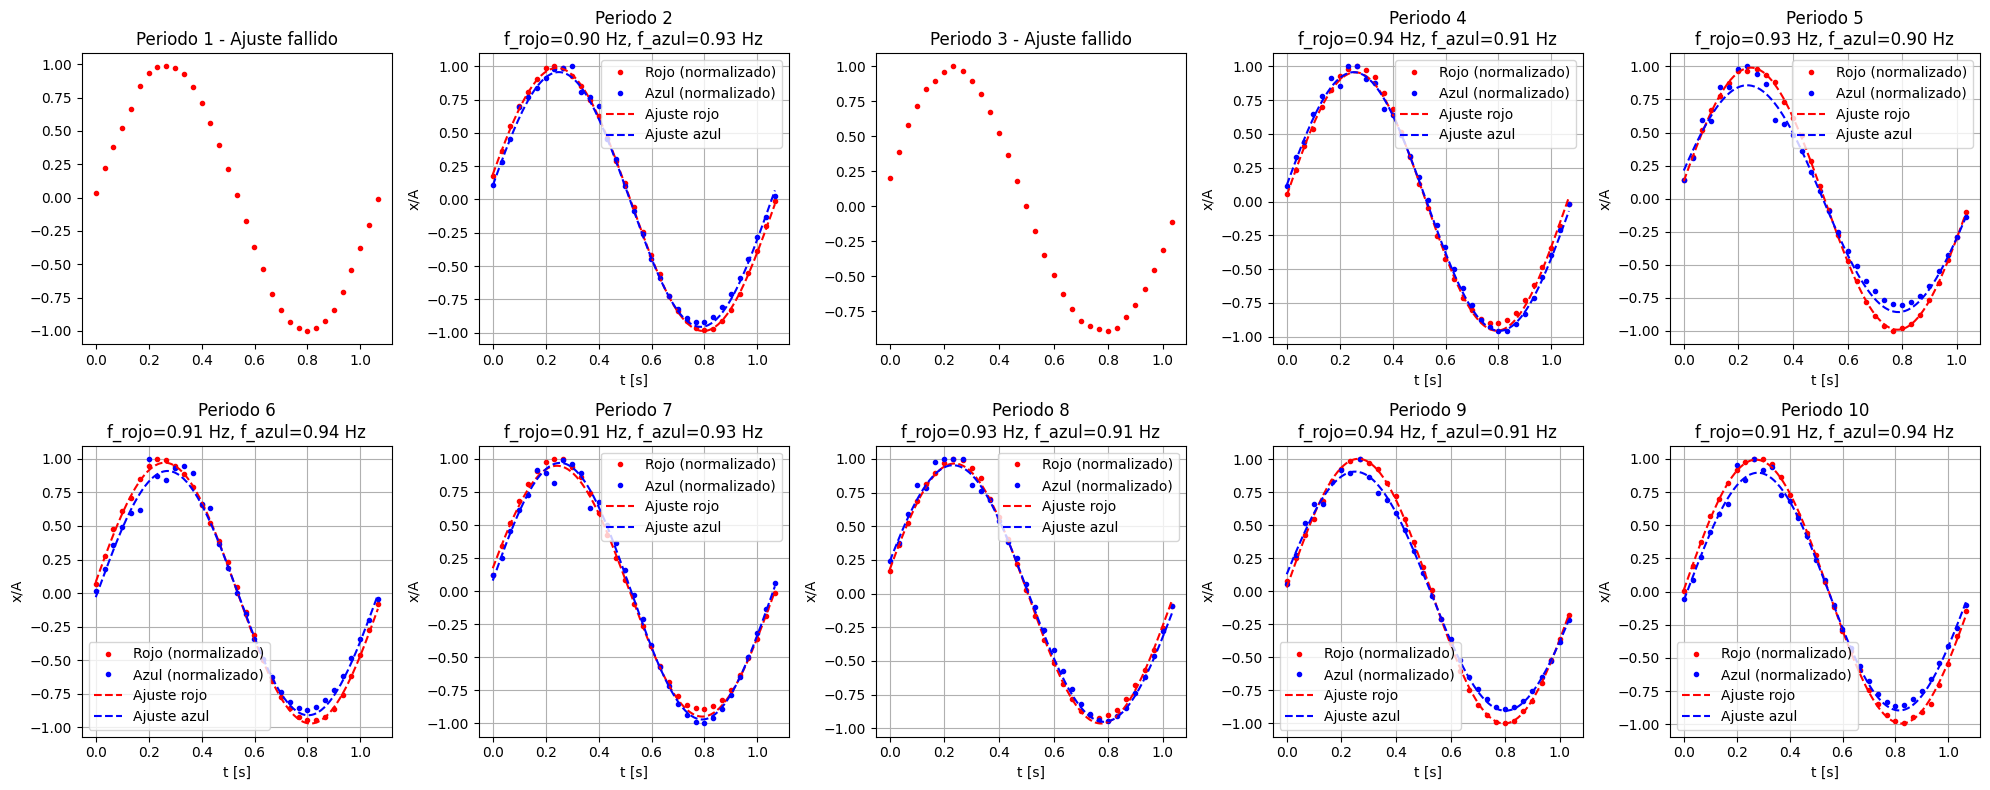

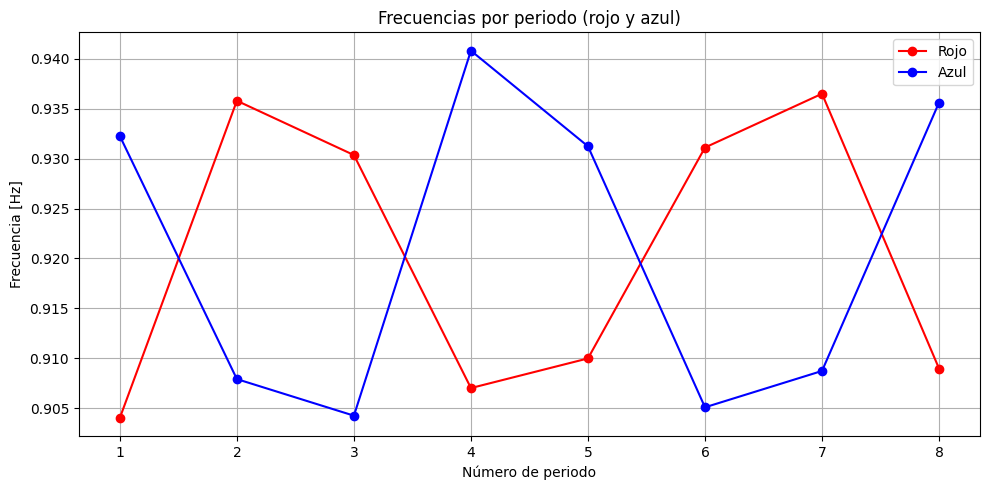


Frecuencia promedio rojo: 0.920 ± 0.013 Hz
Frecuencia promedio azul: 0.921 ± 0.015 Hz


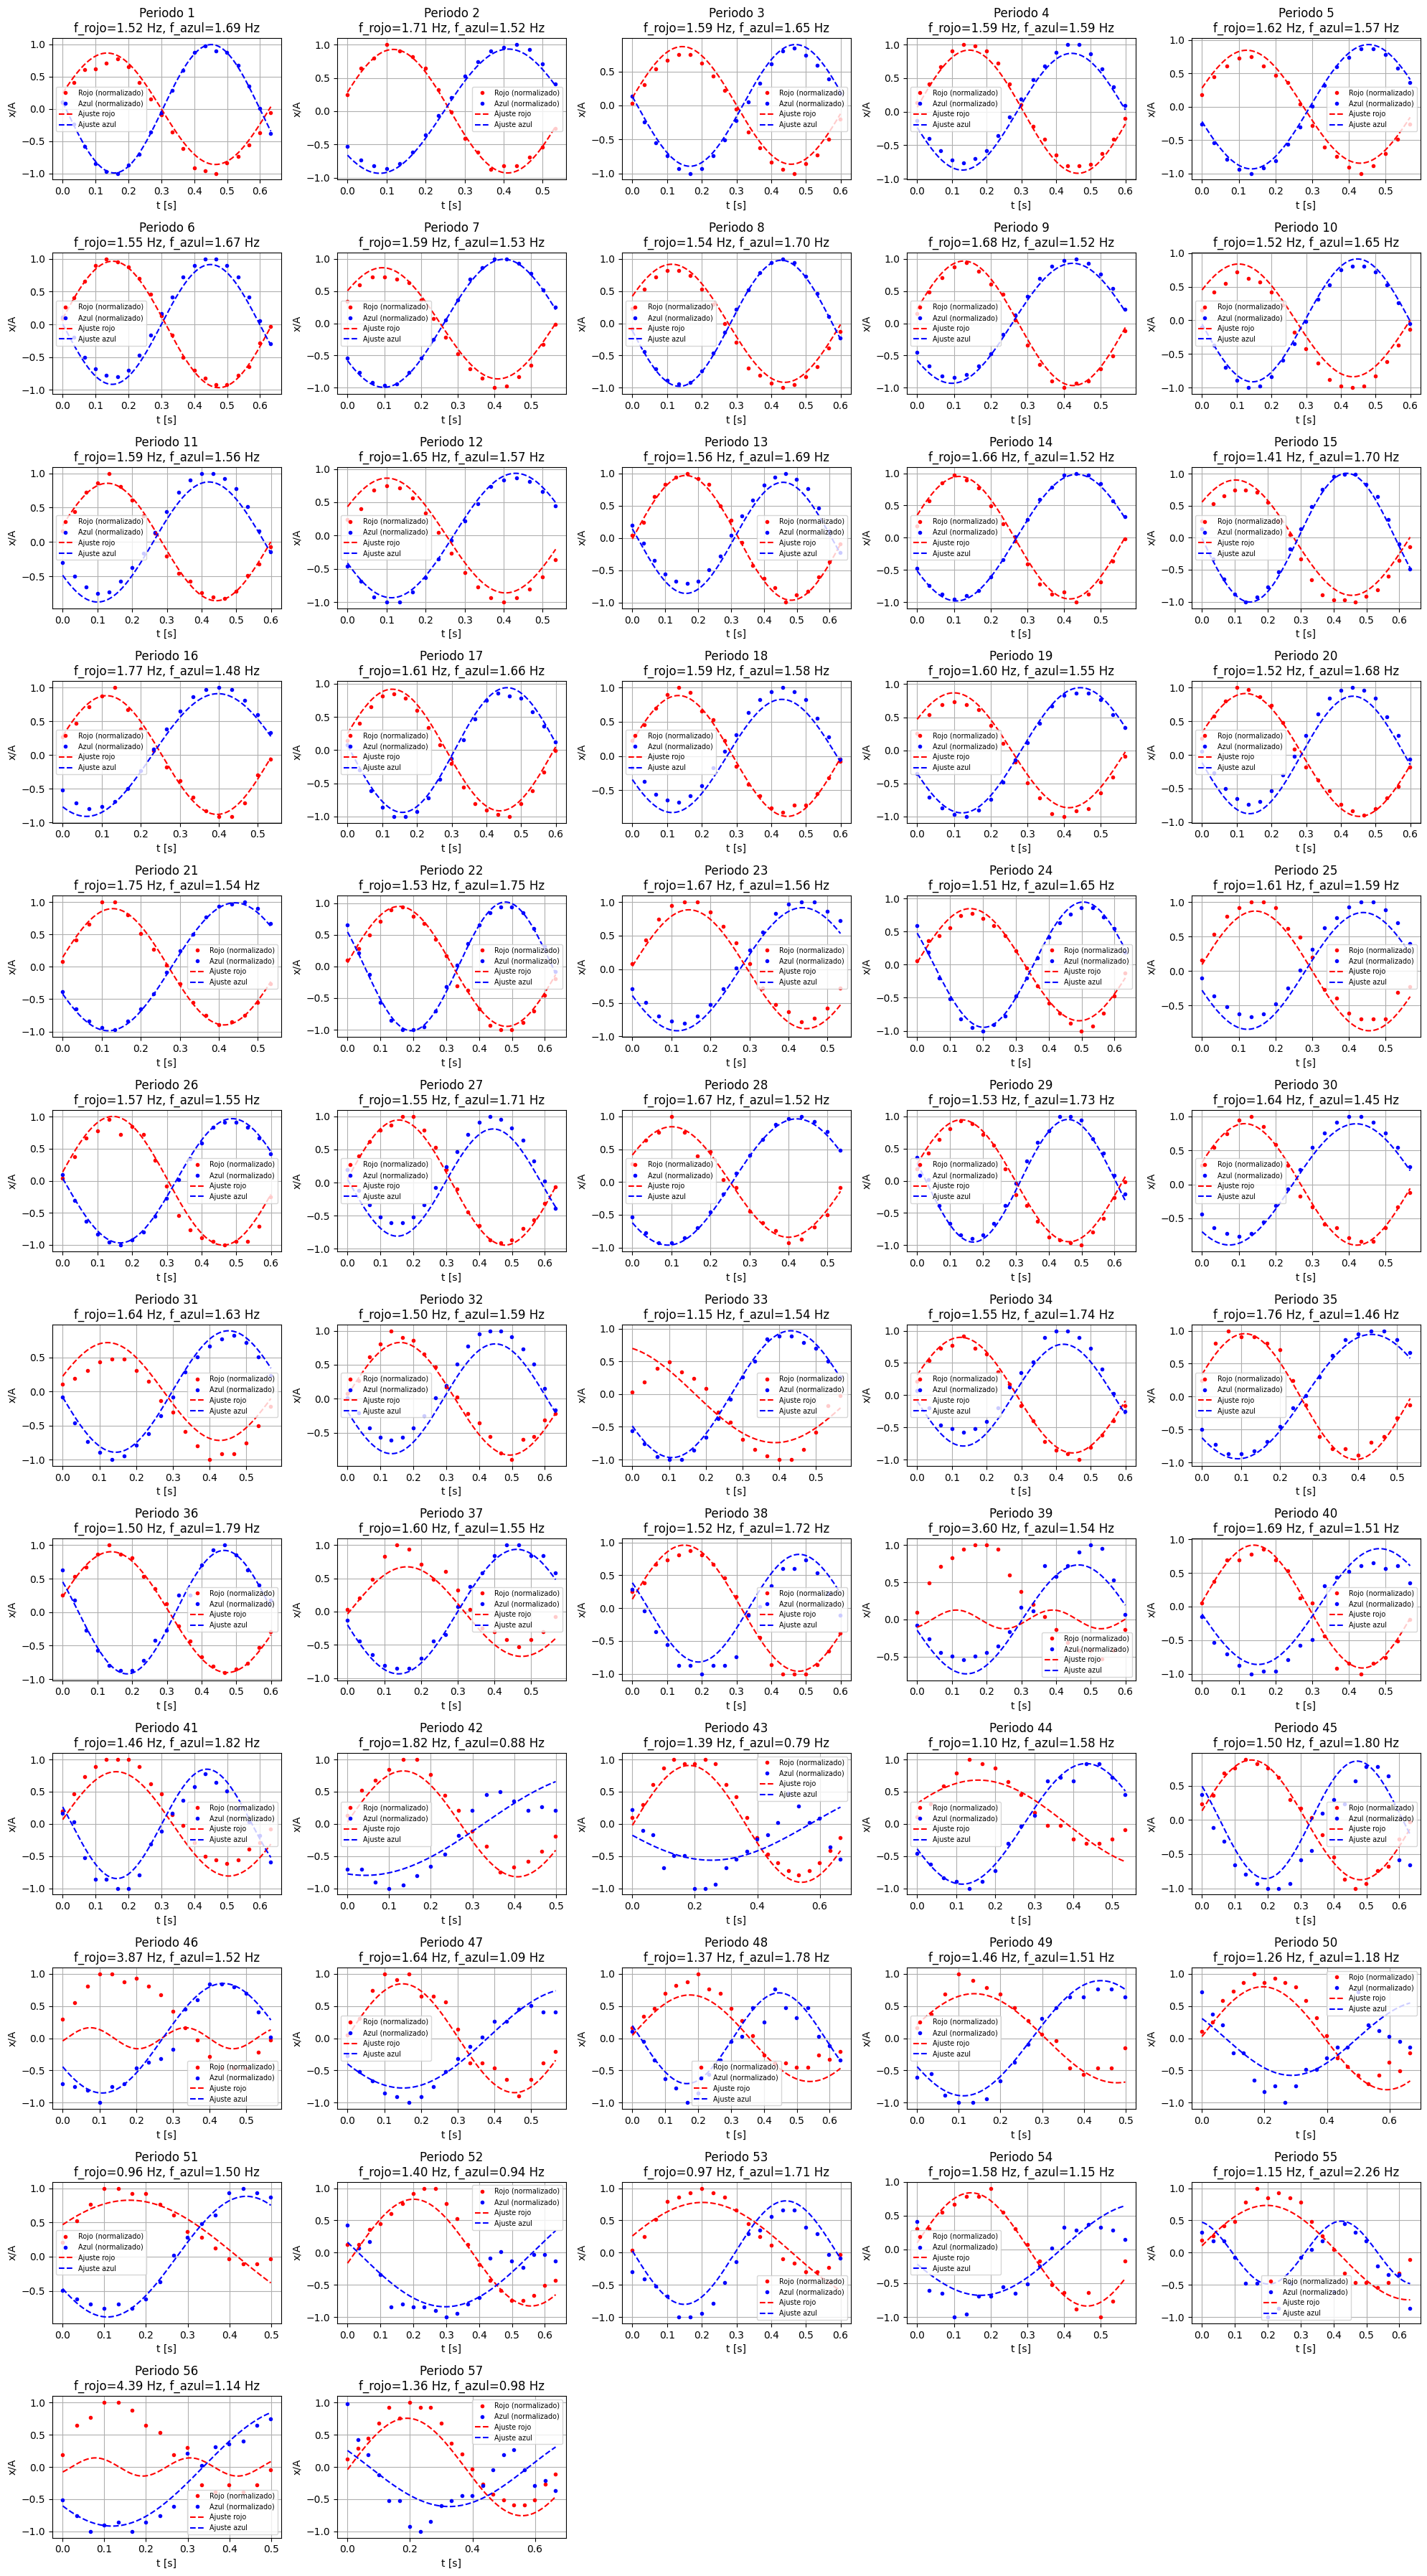

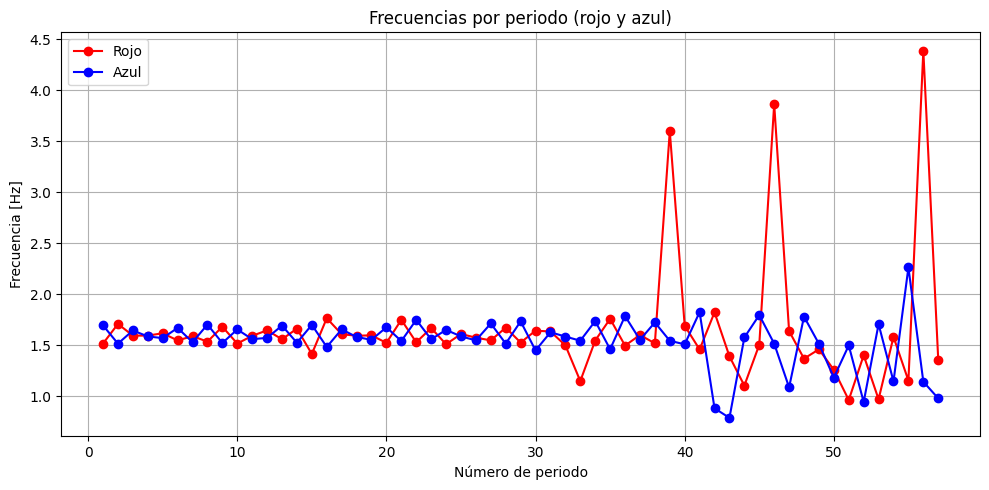


Frecuencia promedio rojo: 1.651 ± 0.575 Hz
Frecuencia promedio azul: 1.541 ± 0.249 Hz


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === 1. Cargar datos ===
df = pd.read_csv('/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosModoRapido/trayectorias.csv')
# === 2. Centrar ambas señales ===
df['x_rojo_c'] = df['x_rojo'] - df['x_rojo'].mean()
df['x_azul_c'] = df['x_azul'] - df['x_azul'].mean()
t = df['tiempo_s'].values
x1 = df['x_rojo_c'].values
x2 = df['x_azul_c'].values

# === 3. Detectar cruces por cero positivos en rojo ===
cruces_cero = []
for i in range(1, len(x1)):
    if x1[i-1] < 0 and x1[i] >= 0:
        t0 = t[i-1] + (0 - x1[i-1]) * (t[i] - t[i-1]) / (x1[i] - x1[i-1])
        cruces_cero.append((i, t0))

# === 4. Separar periodos de ambas señales ===
periodos = []
for i in range(len(cruces_cero)-1):
    idx_ini = cruces_cero[i][0]
    idx_fin = cruces_cero[i+1][0]
    t_p = t[idx_ini:idx_fin] - t[idx_ini]
    x1_p = x1[idx_ini:idx_fin]
    x2_p = x2[idx_ini:idx_fin]
    
    A1 = np.max(np.abs(x1_p))
    A2 = np.max(np.abs(x2_p))
    
    if A1 != 0 and A2 != 0:
        periodos.append((t_p, x1_p / A1, x2_p / A2))

# === 5. Modelo a ajustar ===
def modelo(t, A, w, phi):
    return A * np.cos(w * t + phi)

# === 6. Ajustar periodos y guardar frecuencias ===
frecs_rojo = []
frecs_azul = []

# Configurar subplots
num_periodos = len(periodos)
cols = 5
rows = int(np.ceil(num_periodos / cols))
fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axs = axs.flatten()

for i, (t_p, x1_p, x2_p) in enumerate(periodos):
    T_esti = t_p[-1] - t_p[0]
    p0 = [1, 2*np.pi / T_esti, 0]

    try:
        popt1, _ = curve_fit(modelo, t_p, x1_p, p0=p0)
        popt2, _ = curve_fit(modelo, t_p, x2_p, p0=p0)
        
        w1 = popt1[1]
        w2 = popt2[1]
        f1 = w1 / (2 * np.pi)
        f2 = w2 / (2 * np.pi)
        
        frecs_rojo.append(f1)
        frecs_azul.append(f2)

        # Gráfica
        t_fit = np.linspace(t_p.min(), t_p.max(), 200)
        axs[i].plot(t_p, x1_p, 'r.', label='Rojo (normalizado)')
        axs[i].plot(t_p, x2_p, 'b.', label='Azul (normalizado)')
        axs[i].plot(t_fit, modelo(t_fit, *popt1), 'r--', label='Ajuste rojo')
        axs[i].plot(t_fit, modelo(t_fit, *popt2), 'b--', label='Ajuste azul')
        axs[i].set_title(f'Periodo {i+1}\nf_rojo={f1:.2f} Hz, f_azul={f2:.2f} Hz')
        axs[i].legend(fontsize='x-small')
        axs[i].grid(True)
        axs[i].set_xlabel('t [s]')
        axs[i].set_ylabel('x/A')

    except Exception as e:
        axs[i].plot(t_p, x1_p, 'r.')
        axs[i].plot(t_p, x2_p, 'b.')
        axs[i].set_title(f'Periodo {i+1} - Ajuste fallido')
        print(f"Fallo en periodo {i+1}: {e}")

# Ocultar subplots vacíos
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# === 7. Gráfico resumen: frecuencia vs periodo ===
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(frecs_rojo)+1), frecs_rojo, 'ro-', label='Rojo')
plt.plot(range(1, len(frecs_azul)+1), frecs_azul, 'bo-', label='Azul')
plt.xlabel('Número de periodo')
plt.ylabel('Frecuencia [Hz]')
plt.title('Frecuencias por periodo (rojo y azul)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 8. Promedios y dispersión ===
prom_r = np.mean(frecs_rojo)
std_r = np.std(frecs_rojo)
prom_a = np.mean(frecs_azul)
std_a = np.std(frecs_azul)

print(f'\nFrecuencia promedio rojo: {prom_r:.3f} ± {std_r:.3f} Hz')
print(f'Frecuencia promedio azul: {prom_a:.3f} ± {std_a:.3f} Hz')


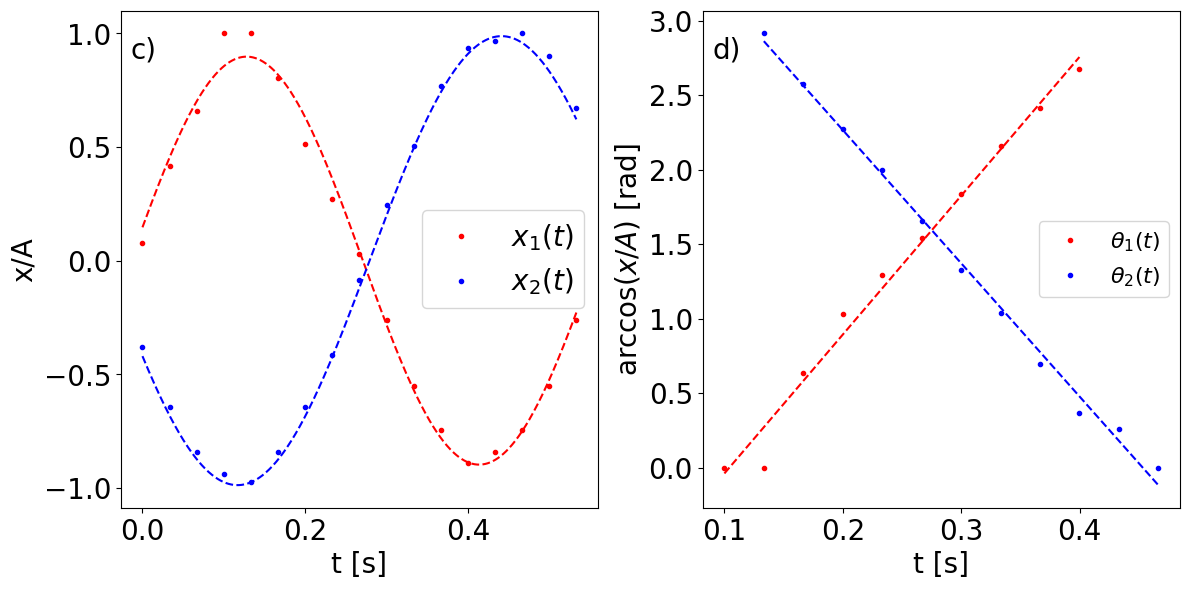

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# === 0. Configuración de estilo de gráficos ===
sizeLetras = 20

# === 1. Cargar datos ===
df = pd.read_csv('/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosModoRapido/trayectorias.csv')
df['x_rojo_c'] = df['x_rojo'] - df['x_rojo'].mean()
df['x_azul_c'] = df['x_azul'] - df['x_azul'].mean()
t = df['tiempo_s'].values
x1 = df['x_rojo_c'].values
x2 = df['x_azul_c'].values

# === 3. Detectar cruces por cero positivos en rojo ===
cruces_cero = []
for i in range(1, len(x1)):
    if x1[i-1] < 0 and x1[i] >= 0:
        t0 = t[i-1] + (0 - x1[i-1]) * (t[i] - t[i-1]) / (x1[i] - x1[i-1])
        cruces_cero.append((i, t0))

# === 4. Obtener el periodo 27 ===
i =20
idx_ini = cruces_cero[i][0]
idx_fin = cruces_cero[i+1][0]
t_p = t[idx_ini:idx_fin] - t[idx_ini]
x1_p = x1[idx_ini:idx_fin]
x2_p = x2[idx_ini:idx_fin]

# === 5. Ajuste con modelo coseno ===
def modelo(t, A, w, phi):
    return A * np.cos(w * t + phi)

# Estimación inicial
T_est = t_p[-1] - t_p[0]
w_est = 2 * np.pi / T_est
p0 = [np.max(np.abs(x1_p)), w_est, 0]

# Ajustes
popt1, _ = curve_fit(modelo, t_p, x1_p, p0=p0)
popt2, _ = curve_fit(modelo, t_p, x2_p, p0=p0)

# === 6. Normalizar por amplitud ===
A1 = np.max(np.abs(x1_p))
A2 = np.max(np.abs(x2_p))
x1_n = x1_p / A1
x2_n = x2_p / A2

# === 7. Datos para arccos entre mínimo y máximo ===
def datos_arccos(t_p, x_n):
    idx_min = np.argmin(x_n)
    idx_max = np.argmax(x_n)
    if idx_min > idx_max:
        idx_min, idx_max = idx_max, idx_min
    # Ignorar primeros y últimos 2 puntos para evitar extremos inestables
    idx_min += 0
    idx_max -= 0
    t_seg = t_p[idx_min:idx_max+1]
    y_seg = np.arccos(x_n[idx_min:idx_max+1])
    return t_seg, y_seg

t1_arccos, y1_arccos = datos_arccos(t_p, x1_n)
t2_arccos, y2_arccos = datos_arccos(t_p, x2_n)

# === 8. Regresiones lineales ===
def ajuste_lineal(t, y):
    slope, intercept, r_value, _, stderr = linregress(t, y)
    return slope, intercept, r_value**2, stderr

slope1, intercept1, r2_1, err1 = ajuste_lineal(t1_arccos, y1_arccos)
slope2, intercept2, r2_2, err2 = ajuste_lineal(t2_arccos, y2_arccos)

# === 9. Graficar ambos análisis ===
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# --- 9a. Señal normalizada y ajuste coseno ---
t_fit = np.linspace(t_p.min(), t_p.max(), 500)
axs[0].plot(t_p, x1_n, 'r.', label='$x_1(t)$')
axs[0].plot(t_p, x2_n, 'b.', label='$x_2(t)$')
axs[0].plot(t_fit, modelo(t_fit, *popt1)/A1, 'r--')
axs[0].plot(t_fit, modelo(t_fit, *popt2)/A2, 'b--')
axs[0].set_xlabel('t [s]', fontsize=sizeLetras)
axs[0].set_ylabel('x/A', fontsize=sizeLetras)
axs[0].tick_params(labelsize=sizeLetras)
axs[0].legend(fontsize=sizeLetras)
axs[0].text(0.02, 0.95, 'c)', transform=axs[0].transAxes,
            fontsize=sizeLetras, verticalalignment='top')

# --- 9b. arccos(x/A) y regresión lineal ---
axs[1].plot(t1_arccos, y1_arccos, 'r.', label=r'$\theta_1(t)$')
axs[1].plot(t1_arccos, slope1*t1_arccos + intercept1, 'r--')
axs[1].plot(t2_arccos, y2_arccos, 'b.', label=r'$\theta_2(t)$')    
axs[1].plot(t2_arccos, slope2*t2_arccos + intercept2, 'b--')
axs[1].set_xlabel('t [s]', fontsize=sizeLetras)
axs[1].set_ylabel(r'$\arccos(x/A)$ [rad]', fontsize=sizeLetras)
axs[1].tick_params(labelsize=sizeLetras)
axs[1].legend(fontsize=sizeLetras-4)
axs[1].text(0.02, 0.95, 'd)', transform=axs[1].transAxes,
            fontsize=sizeLetras, verticalalignment='top')

plt.tight_layout()
plt.show()

